## CDNOW ML Project : Customer lifetime value analysis

In [1]:
# Import libraries/packages

import pandas as pd
import numpy as np
import joblib
import plydata.cat_tools as cat
import plotnine as pn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pn.options.dpi = 300

In [2]:
# Importing ML model

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
# importing dataset

cdnow = pd.read_csv('E:\Data Science\CDNOW_Dataset.csv', parse_dates=[2])
cdnow.head()

,Id,customer_id,order_date,units,sales
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76


In [4]:
# Dropping unnamed index column

Raw_data = cdnow.drop(cdnow.columns[0], axis=1)
Raw_data.head()

,customer_id,order_date,units,sales
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [5]:
Raw_data.shape

(69659, 4)

In [6]:
Raw_data.describe()

,customer_id,units,sales
count,69659.000000,69659.000000,69659.000000
mean,11470.854592,2.410040,35.850581
std,6819.904848,2.333924,35.551864
min,1.000000,1.000000,0.000000
25%,5506.000000,1.000000,14.490000
50%,11410.000000,2.000000,25.980000
75%,17273.000000,3.000000,43.700000
max,23570.000000,99.000000,932.230000


In [7]:
Raw_data.columns

Index(['customer_id', 'order_date', 'units', 'sales'], dtype='object')

In [8]:
Raw_data.info() # order_date is in object format we have changed it to datetime format while importing data using 'parse_dates=[2]'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   order_date   69659 non-null  datetime64[ns]
 2   units        69659 non-null  int64         
 3   sales        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [9]:
# Checking for NA values
Raw_data.isnull().sum() # No NA values found

customer_id    0
order_date     0
units          0
sales          0
dtype: int64

In [10]:
# Fill NA if any NA remained
cdnow_raw_data = Raw_data.fillna(Raw_data)
cdnow_raw_data.head()

,customer_id,order_date,units,sales
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [11]:
cdnow_raw_data.corr()

,customer_id,units,sales
customer_id,1.000000,-0.002319,-0.008267
units,-0.002319,1.000000,0.891241
sales,-0.008267,0.891241,1.000000


#### COHORT Analysis:

In [16]:
# Only the customers that have joined at the specific business day
# Get range of initial purchases
cdnow_first_purchase = cdnow_raw_data.sort_values(['customer_id', 'order_date']).groupby('customer_id').first()
cdnow_first_purchase

,order_date,units,sales
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [17]:
cdnow_first_purchase['order_date'].min()

Timestamp('1997-01-01 00:00:00')

In [18]:
cdnow_first_purchase['order_date'].max()

Timestamp('1997-03-25 00:00:00')

<AxesSubplot:xlabel='order_date'>

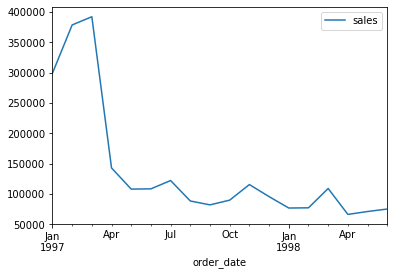

In [19]:
# Visualize all the purchases within cohort
cdnow_raw_data.reset_index().set_index('order_date')[['sales']].resample(rule="MS").sum().plot()

In [21]:
# Visualize individual customer purchase
id = cdnow_raw_data['customer_id'].unique()
id_selected = id[0:10]
id_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [24]:
# Creating pivot to test first ten customers buying pattern
cdnow_custid_subset = cdnow_raw_data[cdnow_raw_data['customer_id'].isin(id_selected)].groupby(['customer_id', 'order_date']).sum().reset_index()
cdnow_custid_subset

,customer_id,order_date,units,sales
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


C:\Users\Administrator\anaconda3\lib\site-packages\plotnine\scales\scale.py:102: PlotnineWarning: scale_x_datetime could not recognise parameter `date_lable`
C:\Users\Administrator\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


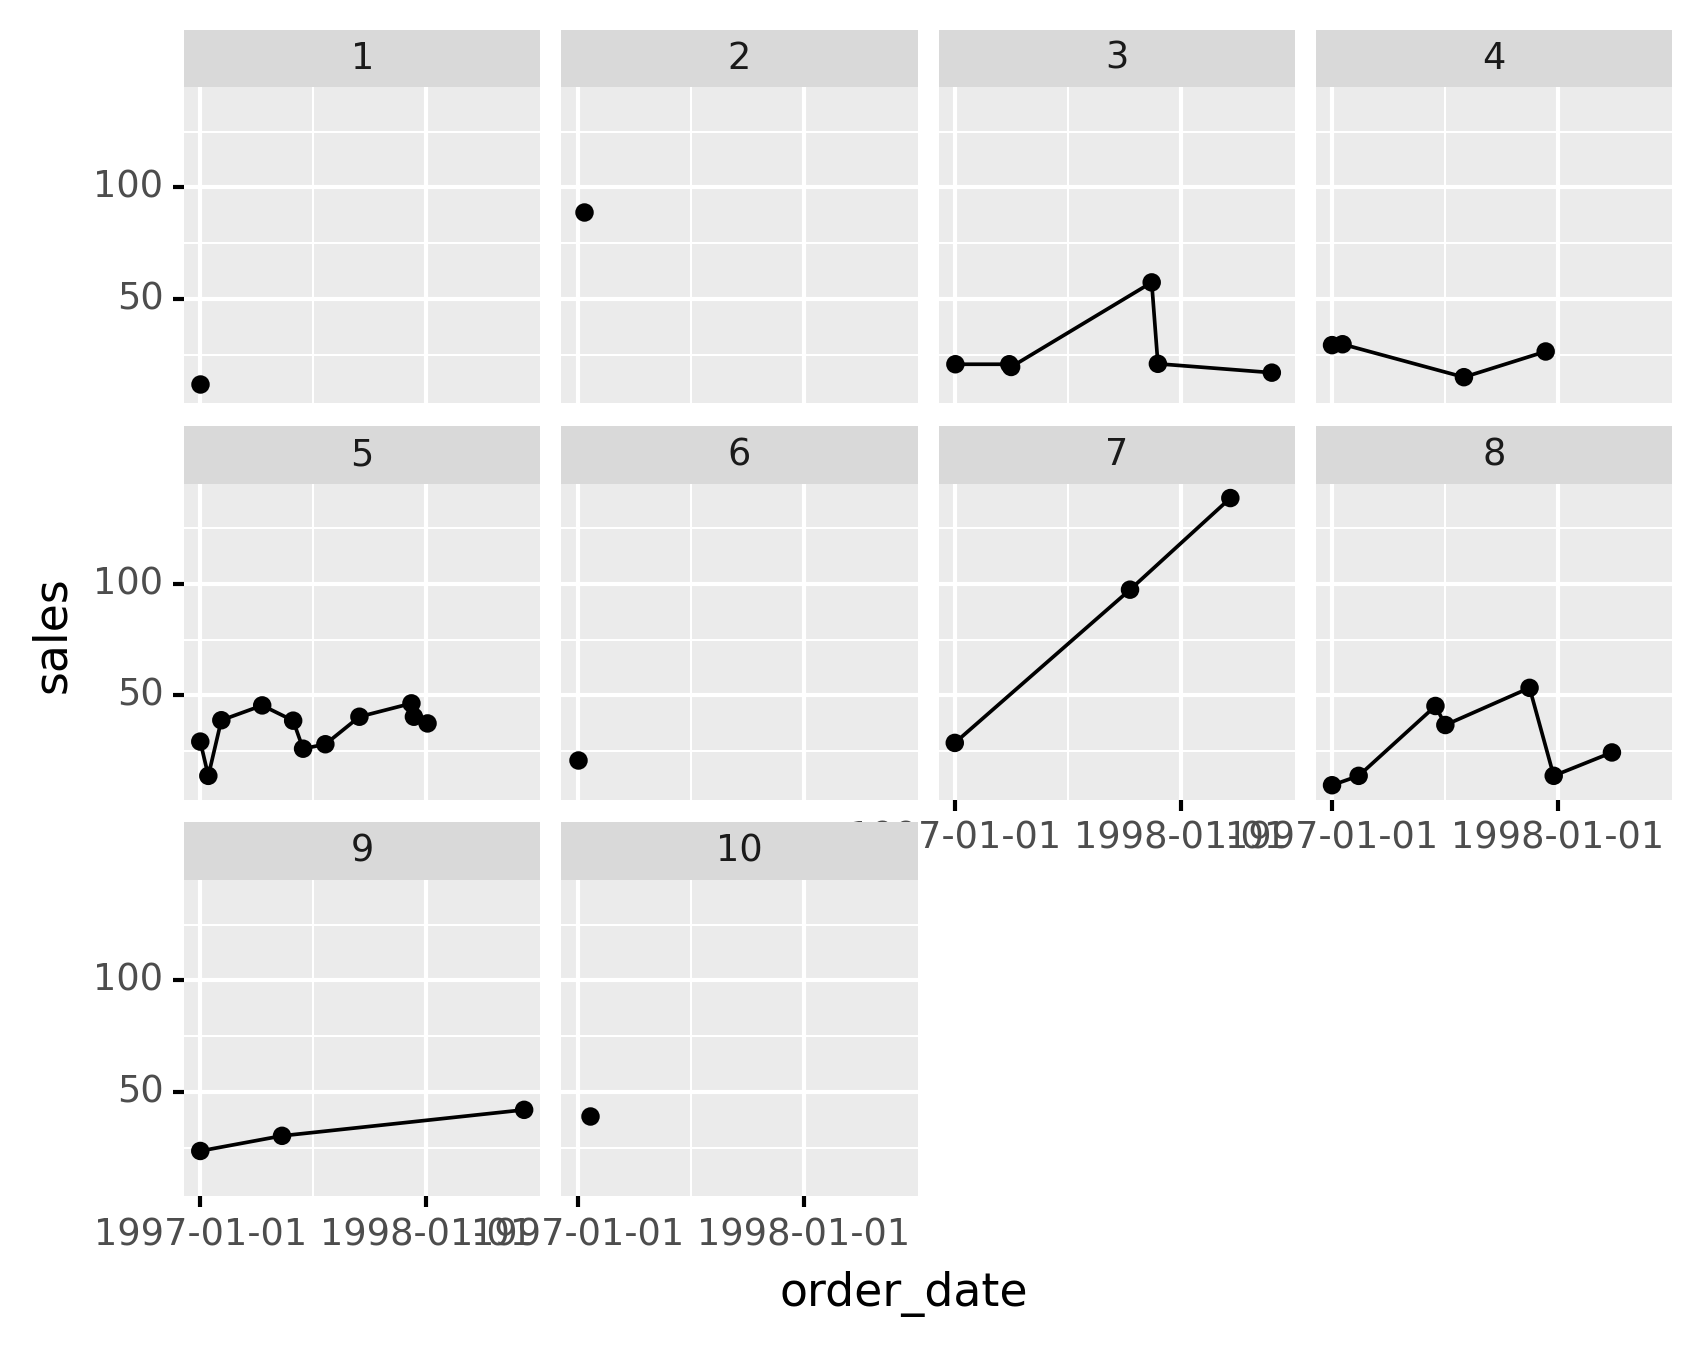

<ggplot: (137710185539)>

In [26]:
# Visualizing those 10 customers buying pattern
pn.ggplot(
pn.aes('order_date', 'sales', group = 'customer_id'), data = cdnow_custid_subset) + pn.geom_line()+pn.geom_point()+pn.facet_wrap('customer_id')+pn.scale_x_date(date_breaks = "1 year",date_lable = "%Y")

### MACHINE LERNING:

#### 1. What will the customer spend in the next 90 days? (Regression Problem)
#### 2. What is the probability of a customer to make a purchase in next 90 days? (Classification Problem)

In [29]:
# Time splitting
n_days = 90
max_date = cdnow_raw_data['order_date'].max() # Checking the max date
cutoff = max_date - pd.to_timedelta(n_days, unit="d") # subtracting max date from last 90 days

In [32]:
in_date = cdnow_raw_data[cdnow_raw_data['order_date'] <= cutoff] # in date
out_date = cdnow_raw_data[cdnow_raw_data['order_date'] > cutoff] # out date